# About The Dataset

- The Coral Spawning Database includes over 6,000 observations of the time or day of spawning for over 300 scleractinian species from 101 sites in the Indo-Pacific.

### Dataset: 
- [The coral spawning database](https://data.ncl.ac.uk/articles/dataset/Coral_Spawning_Database/13082333/1?file=25048202)


### Reference
- Baird, A.H., Guest, J.R., Edwards, A.J. et al. [An Indo-Pacific coral spawning database](https://www.nature.com/articles/s41597-020-00793-8#Abs1). Sci Data 8, 35 (2021). https://doi.org/10.1038/s41597-020-00793-8

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, PoissonRegressor, TweedieRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# 01_Get the Data

In [2]:
df = pd.read_csv('coral_spawning_cleaned.csv')
#data.info()
print(df.shape)
df.head()

(4396, 19)


Ecoregion         Country      Site   Latitude   Longitude  \
0  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu -14.279444 -170.700833   
1  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu -14.279444 -170.700833   
2  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu -14.279444 -170.700833   
3  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu -14.279444 -170.700833   
4  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu -14.279444 -170.700833   

       Genus     Species                Taxon  N_min        Date  \
0    Porites  cylindrica  Porites  cylindrica    1.0  1988-10-27   
1    Porites  cylindrica  Porites  cylindrica   15.0  1995-11-09   
2   Acropora    muricata   Acropora  muricata    1.0  1995-11-10   
3   Merulina    ampliata   Merulina  ampliata    6.0  1995-11-11   
4  Montipora      grisea    Montipora  grisea    3.0  1995-11-11   

   Start_decimal     STrSS Gamete_release  DoSRtNFM  ToSS_decimal  \
0      20.500000  2.116667          Sperm         3     18.383333   
1      20.583333  2.116667          Sperm         3     18.466667   
2      20.333333  1.866667        Bundles         4     18.466667   
3      19.750000  1.283333        Bundles         5     18.466667   
4      20.750000  2.283333        Bundles         5     18.466667   

   ToSR_decimal  daylen_decimal  sunset  sunrise  
0      5.816667           13.34   18.23     5.49  
1      5.750000           13.42   18.27     5.45  
2      5.750000           13.43   18.28     5.45  
3      5.733333           13.44   18.28     5.44  
4      5.733333           13.44   18.28     5.44

# 02_Data Processing
## Categorical Independency
- Before building a model, let's check correlation between columns

In [3]:
# Separate categorical and numerical data
cat = df.select_dtypes(include='object')
num = df.select_dtypes(include='number')

## Chi-square test
- Let's start with categorical dependency
- We will apply Chi-square test to check the independence between two categorical columns


Start by setting hypothesis

    Ho — There is no relationship between the two variables
    Ha — There is relationship between the two variables

In [4]:
def categoricals_dependency(col_1, col_2, significance_level):
    """
    The function test the dependency between two categorical columns.
    By giving the level of significant, 
    the function returns the result if the H0 is accepted or rejected
    """
    contingency_table = pd.crosstab(col_1, col_2)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    significance_level = significance_level
    
    print(f'Independency test between "{col_1.name}" and "{col_2.name}":')
    print(f'Chi-square value: {chi2:.4f}')
    print(f'Degrees of freedom: {dof}')
    print(f'p-value: {p_value:.4f}', "\n")
    if p_value <= significance_level: 
        print(f'Result: REJECT NULL HYPOTHESIS with p-value {p_value}') 
    else: 
        print(f'Result: ACCEPT NULL HYPOTHESIS with p-value {p_value}')

## Check geographical data

In [5]:
categoricals_dependency(cat['Ecoregion'], cat['Country'], 0.05)

Independency test between "Ecoregion" and "Country":
Chi-square value: 96712.0000
Degrees of freedom: 736
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


In [6]:
categoricals_dependency(cat['Ecoregion'], cat['Site'], 0.05)

Independency test between "Ecoregion" and "Site":
Chi-square value: 140672.0000
Degrees of freedom: 2720
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


In [7]:
categoricals_dependency(cat['Country'], cat['Site'], 0.05)

Independency test between "Country" and "Site":
Chi-square value: 101108.0000
Degrees of freedom: 1955
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


### Result
- There is correlation between those pairs of variables

- We can pick only one to train the model

    - If we want to be more specific about the site, 
        - we should include 'Site' in the model 
        - or include 'Ecoregion' to not be too specific. (Also, we will have less data to process. The model runs faster because we have less unique value with Ecoregion. )

## Check coral name (Genus, Species, Taxon) independency

In [8]:
categoricals_dependency(cat['Genus'], df['Species'], 0.05)

Independency test between "Genus" and "Species":
Chi-square value: 200227.0099
Degrees of freedom: 13520
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


In [9]:
categoricals_dependency(cat['Genus'], cat['Taxon'], 0.05)

Independency test between "Genus" and "Taxon":
Chi-square value: 228592.0000
Degrees of freedom: 17940
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


In [10]:
categoricals_dependency(cat['Species'], cat['Taxon'], 0.05)

Independency test between "Species" and "Taxon":
Chi-square value: 1142960.0000
Degrees of freedom: 89700
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


In [11]:
categoricals_dependency(cat['Genus'], cat['Gamete_release'], 0.05)

Independency test between "Genus" and "Gamete_release":
Chi-square value: 4434.0073
Degrees of freedom: 208
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


In [12]:
categoricals_dependency(cat['Species'], cat['Gamete_release'], 0.05)

Independency test between "Species" and "Gamete_release":
Chi-square value: 6244.9883
Degrees of freedom: 1040
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


In [13]:
categoricals_dependency(cat['Taxon'], cat['Gamete_release'], 0.05)

Independency test between "Taxon" and "Gamete_release":
Chi-square value: 7206.0745
Degrees of freedom: 1380
p-value: 0.0000 

Result: REJECT NULL HYPOTHESIS with p-value 0.0


### Result
- There is correlation between those pairs of variables

---

## Numerical data

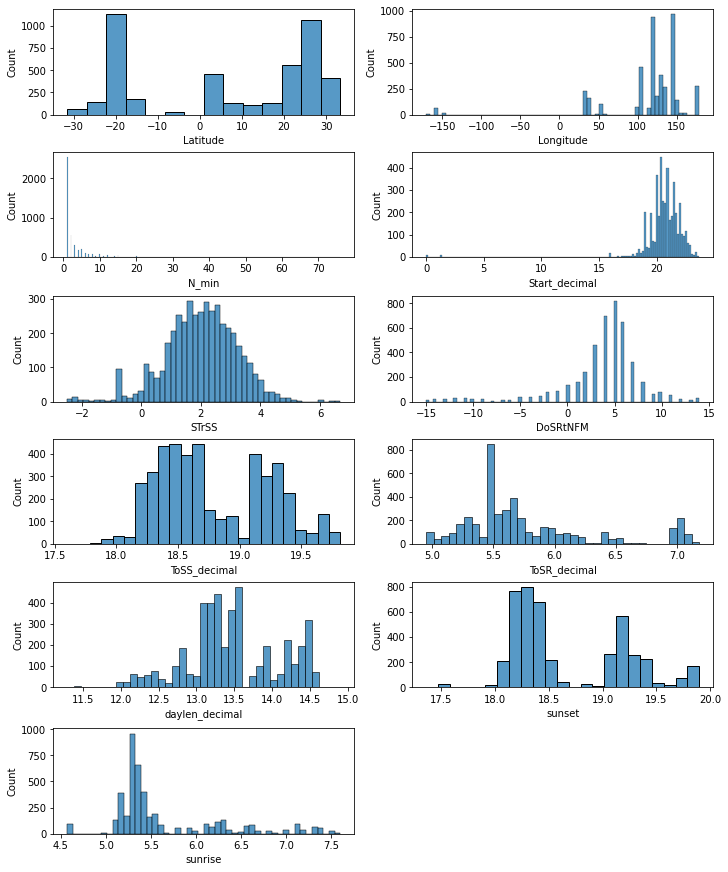

In [14]:
# Check distribution of numerical data
fig = plt.figure(figsize = (10, 12), constrained_layout = True)

for i, column in enumerate(num.columns):
    fig.add_subplot(6, 2, i + 1) 
    sns.histplot(num[column])

# Numerical data correlation
- Check multicollinearity among numerical variables

                Latitude  Longitude  N_min  Start_decimal  STrSS  DoSRtNFM  \
Latitude            1.00      -0.38   0.25           0.00  -0.15     -0.26   
Longitude          -0.38       1.00  -0.13           0.17   0.15      0.27   
N_min               0.25      -0.13   1.00          -0.04  -0.13     -0.11   
Start_decimal       0.00       0.17  -0.04           1.00   0.46      0.02   
STrSS              -0.15       0.15  -0.13           0.46   1.00      0.13   
DoSRtNFM           -0.26       0.27  -0.11           0.02   0.13      1.00   
ToSS_decimal        0.42      -0.29   0.14           0.01  -0.28     -0.21   
ToSR_decimal       -0.10      -0.19  -0.14           0.01  -0.11     -0.01   
daylen_decimal      0.27      -0.02   0.15          -0.02  -0.17     -0.16   
sunset              0.33      -0.27   0.08           0.01  -0.26     -0.17   
sunrise            -0.04      -0.18  -0.11           0.04  -0.06      0.01   

                ToSS_decimal  ToSR_decimal  daylen_decimal  sun

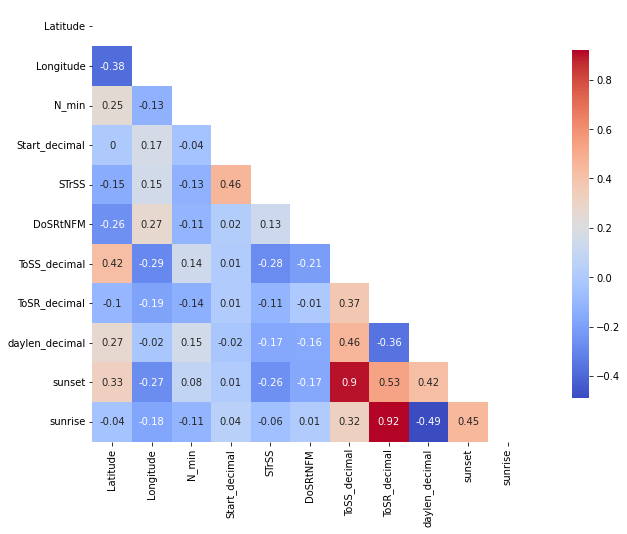

In [15]:
# Check correlation score
data_corr = num.corr()
data_corr = round(data_corr,2)
print(data_corr)

# Visualize correlation matrix
correlations_matrix = round(data_corr,2)
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True, square=True, cbar_kws={"shrink":.8}, cmap='coolwarm')

## Observation
### Multicollinearity spotted

- From the heatmap, we see 'ToSS_decimal', 'ToSR_decimal' are highly correlated with sunset and sunrise respectively. So we will drop these two variables.



###  Drop variable that is identical to the target

- Since I have tried training the model including 'STrSS' column as a feature and got R^2 = 1.0 which was weird. 
- The 'STrSS' columns was not described in the [document](https://www.nature.com/articles/s41597-020-00793-8#Abs1). But luckily, there is another table with the sunset_time, sunrise_time. I was able to find out how this 'STrSS' was calculated. 
- It is calculated directly from our target. That means, you have to know exactly what time coral spawns. Then you'll have this 'STrSS' value afterward. In other words, it is identical with the target.
- Therefore, 'STrSS' needed to be gone.

### Drop columns that will not be used for training the model
- These two are not useful for training the model: 'Latitude', 'Longitude'

In [16]:
# drop unwanted columns
df = df.drop(['ToSS_decimal', 'ToSR_decimal', 'STrSS', 'Latitude', 'Longitude'], axis=1)
# df.head()

In [17]:
# Separate categorical and numerical data
cat = df.select_dtypes(include='object')
num = df.select_dtypes(include='number')

                N_min  Start_decimal  DoSRtNFM  daylen_decimal  sunset  \
N_min            1.00          -0.04     -0.11            0.15    0.08   
Start_decimal   -0.04           1.00      0.02           -0.02    0.01   
DoSRtNFM        -0.11           0.02      1.00           -0.16   -0.17   
daylen_decimal   0.15          -0.02     -0.16            1.00    0.42   
sunset           0.08           0.01     -0.17            0.42    1.00   
sunrise         -0.11           0.04      0.01           -0.49    0.45   

                sunrise  
N_min             -0.11  
Start_decimal      0.04  
DoSRtNFM           0.01  
daylen_decimal    -0.49  
sunset             0.45  
sunrise            1.00  


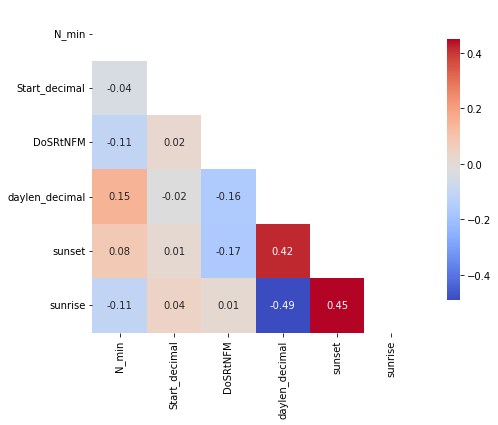

In [18]:
### Check numerical correlation again after dealing with the multicollinearity
data_corr = num.corr()
data_corr = round(data_corr,2)
print(data_corr)

# Visualize correlation matrix
correlations_matrix = round(data_corr,2)
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True, square=True, cbar_kws={"shrink":.8}, cmap='coolwarm')

---

# 03_Machine Learning | Spawning Time Prediction
### Target
- Our main goal is to **predict time the coral will spawn**
- Therefore, the target is **'Start_decimal'**

In [19]:
# Define y (target)
y_base = df[['Start_decimal']]

# Drop target to get all features
features = df.drop('Start_decimal', axis=1)
features.head()

Ecoregion         Country      Site      Genus     Species  \
0  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu    Porites  cylindrica   
1  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu    Porites  cylindrica   
2  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu   Acropora    muricata   
3  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu   Merulina    ampliata   
4  Tuvalu, Samoa and Tonga  American Samoa  Faga’alu  Montipora      grisea   

                 Taxon  N_min        Date Gamete_release  DoSRtNFM  \
0  Porites  cylindrica    1.0  1988-10-27          Sperm         3   
1  Porites  cylindrica   15.0  1995-11-09          Sperm         3   
2   Acropora  muricata    1.0  1995-11-10        Bundles         4   
3   Merulina  ampliata    6.0  1995-11-11        Bundles         5   
4    Montipora  grisea    3.0  1995-11-11        Bundles         5   

   daylen_decimal  sunset  sunrise  
0           13.34   18.23     5.49  
1           13.42   18.27     5.45  
2           13.43   18.28     5.45  
3           13.44   18.28     5.44  
4           13.44   18.28     5.44

## Feature selection

In [20]:
# To reduce redundancy, we'll remove some geographical data and select some that might be useful to the model
X = features[['Site', 'Taxon', 'N_min', 'Gamete_release', 'DoSRtNFM', 'daylen_decimal', 'sunset', 'sunrise']]
X.head()

Site                Taxon  N_min Gamete_release  DoSRtNFM  \
0  Faga’alu  Porites  cylindrica    1.0          Sperm         3   
1  Faga’alu  Porites  cylindrica   15.0          Sperm         3   
2  Faga’alu   Acropora  muricata    1.0        Bundles         4   
3  Faga’alu   Merulina  ampliata    6.0        Bundles         5   
4  Faga’alu    Montipora  grisea    3.0        Bundles         5   

   daylen_decimal  sunset  sunrise  
0           13.34   18.23     5.49  
1           13.42   18.27     5.45  
2           13.43   18.28     5.45  
3           13.44   18.28     5.44  
4           13.44   18.28     5.44

In [21]:
# Separate categorical & numerical 
cat = X.select_dtypes(include='object')
num = X.select_dtypes(include='number')

In [22]:
# Scale data into (0,1)
transformer = MinMaxScaler().fit(num) 
X_minmax = transformer.transform(num) 

# create new data frame using data from 'x_minmax'
num_scaled = pd.DataFrame(X_minmax, columns = num.columns)
#num_scaled.head() 

In [23]:
# Encoding categorical data
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(cat)
encoded = encoder.transform(cat).toarray() # transform step = encoding step --> get an array as a result 
cat_encoded = pd.DataFrame(encoded).reset_index(drop=True) # put the array into a data frame
cat_encoded.columns = encoder.get_feature_names_out() # name the columns after transformation
cat_encoded.shape

(4396, 434)

In [24]:
# Concat categorical & numerical data into one data frame, X
X_base = pd.concat([num_scaled, cat_encoded], axis=1)
print(X_base.shape)
X_base.head()

(4396, 439)


N_min  DoSRtNFM  daylen_decimal    sunset   sunrise  Site_Airai south  \
0  0.000000  0.620690        0.567867  0.342520  0.303630               0.0   
1  0.186667  0.620690        0.590028  0.358268  0.290429               0.0   
2  0.000000  0.655172        0.592798  0.362205  0.290429               0.0   
3  0.066667  0.689655        0.595568  0.362205  0.287129               0.0   
4  0.026667  0.689655        0.595568  0.362205  0.287129               0.0   

   Site_Akajima  Site_Al Aqah  Site_Al Fahal  Site_Babeldaob  ...  \
0           0.0           0.0            0.0             0.0  ...   
1           0.0           0.0            0.0             0.0  ...   
2           0.0           0.0            0.0             0.0  ...   
3           0.0           0.0            0.0             0.0  ...   
4           0.0           0.0            0.0             0.0  ...   

   Taxon_Scapophyllia  cylindrica  Taxon_Scapophyllia cf cylindrica  \
0                             0.0                               0.0   
1                             0.0                               0.0   
2                             0.0                               0.0   
3                             0.0                               0.0   
4                             0.0                               0.0   

   Taxon_Turbinaria  mesenterina  Taxon_Turbinaria  reniformis  \
0                            0.0                           0.0   
1                            0.0                           0.0   
2                            0.0                           0.0   
3                            0.0                           0.0   
4                            0.0                           0.0   

   Taxon_Turbinaria  sp.  Taxon_Turbinaria  stellulata  \
0                    0.0                           0.0   
1                    0.0                           0.0   
2                    0.0                           0.0   
3                    0.0                           0.0   
4                    0.0                           0.0   

   Gamete_release_Bundles  Gamete_release_Eggs  Gamete_release_Not recorded  \
0                     0.0                  0.0                          0.0   
1                     0.0                  0.0                          0.0   
2                     1.0                  0.0                          0.0   
3                     1.0                  0.0                          0.0   
4                     1.0                  0.0                          0.0   

   Gamete_release_Sperm  
0                   1.0  
1                   1.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 439 columns]

## Baseline model
Let's go as simple as we can get. 

Because our target in continuos data, we will build a simple Linear Regression as a baseline model

In [25]:
# Define a function for model validation

def validate(model_x_condition, y_test, predictions):
    # predictions  = model.predict(X_test)
    r2 = round(r2_score(y_test, predictions), 2)
    MSE = round(mean_squared_error(y_test, predictions), 2)
    RMSE = round(mean_squared_error(y_test, predictions, squared=False), 2)
    MAE = round(mean_absolute_error(y_test, predictions), 2)
    print("R^2: ", r2)
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    
    ### Visualze
    fig, ax = plt.subplots(figsize = (4, 4))
    ax = sns.regplot(y_test, predictions, scatter_kws = {"color": "black", "alpha": 0.5},
                line_kws = {"color": "red"})
    ax.set(xlabel='True', 
           ylabel='Predictions')
    ax.set_title(f"{model_x_condition}")
    
    
    

In [26]:
# Define a function to train and validate the model
def fitting_model(model_x_condition, X_train, X_test, y_train, y_test):
    """
    - Specify the model that you want to build,
    - Giving sets of X_train, X_test, y_train, y_test
    - The function return the evaluation metrics for regression
    
    """
    model = model_x_condition.fit(X_train, y_train) 
    predictions = model.predict(X_test)
    validate(model_x_condition, y_test, predictions)
    return predictions

In [27]:
### Train-Test split

# 25% of data --> test set, 75% --> train set
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.25, random_state=42) 

#Some checks on splitted data
print("TRAIN GROUP: ", len(X_train_base))
print("TEST GROUP: ", len(X_test_base))

TRAIN GROUP:  3297
TEST GROUP:  1099


Baseline model (Linear Regression): 

R^2:  -8.521397933709092e+23
MSE:  4.2196627240173873e+24
RMSE:  2054181765087.35
MAE:  306825665752.64


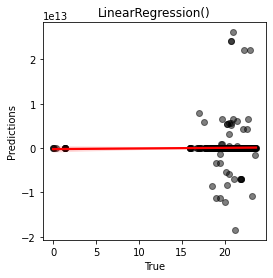

In [28]:
# Building a Linear Regression as a Baseline model
print("Baseline model (Linear Regression):", "\n")
predictions = fitting_model(LinearRegression(), X_train_base, X_test_base, y_train_base, y_test_base)

### Result
- It shows no relationship of the predictors to the target
- As a result, 
    
        R^2:  -8.521397933709092e+23
        MSE:  4.2196627240173873e+24
        RMSE:  2054181765087.35
        MAE:  306825665752.64
- It is the worst model I have ever seen in the entire data analyst projects I have done.

#### What's next? 

- We could work out with those outliers
- So we go to the next step on 'How to improve the model' and try different things under this

# 04_How to Improve the Model
- We can try many different things here
- Let's go one by one

### Visualize outliers

In [29]:
# Outliers in the target data
fig = px.box(df['Start_decimal'], orientation='h',
             width=None, height=None)
fig.show()

### 4.1 Remove outliers

In [30]:
### Remove outliers & visualizing after removing them

# find IQR
iqr = np.percentile(df['Start_decimal'],75) - np.percentile(df['Start_decimal'],25) 

# define the limits
upper_limit = np.percentile(df['Start_decimal'],75) + 4*iqr
lower_limit = np.percentile(df['Start_decimal'],25) - 4*iqr

# remove outliers from the data
df_no_outliers = df[(df['Start_decimal']>lower_limit) & (df['Start_decimal']<upper_limit)]
df_no_outliers = df_no_outliers.reset_index(drop=True)

fig = px.histogram(df_no_outliers['Start_decimal'], marginal="box") 
fig.show()

In [31]:
# Check number of rows after removing outliers
rows_removed = len(df) - len(df_no_outliers)
print("Removed", rows_removed, "rows")
print("Total observations: ", len(df_no_outliers))

Removed 18 rows
Total observations:  4378


### Data processing after removing outliers

In [32]:
# Define y (target)
y_no_outliers = df_no_outliers[['Start_decimal']]

# Define X
X = df_no_outliers[['Site', 'Taxon', 'N_min', 'Gamete_release', 'DoSRtNFM', 'daylen_decimal', 'sunset', 'sunrise']]

# Separate categorical and numerical data
cat = X.select_dtypes(include='object')
num = X.select_dtypes(include='number')

# Encoding categorical data
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(cat)
encoded = encoder.transform(cat).toarray() # transform step = encoding step --> get an array as a result 
cat_encoded = pd.DataFrame(encoded).reset_index(drop=True) # put the array into a data frame
cat_encoded.columns = encoder.get_feature_names_out() # name the columns after transformation
cat_encoded.shape

# Concat categorical & numerical data into one data frame, X
X_no_outliers = pd.concat([num, cat_encoded], axis=1)
print(X_no_outliers.shape)
#X_no_outliers.head()

(4378, 439)


### Training and validating the model (after removing outliers)

Linear Regression after removing outliers: 

R^2:  0.56
MSE:  0.6
RMSE:  0.78
MAE:  0.55


array([[20.79913454],
       [18.77646095],
       [19.12959499],
       ...,
       [20.68492755],
       [18.75535035],
       [21.71252755]])

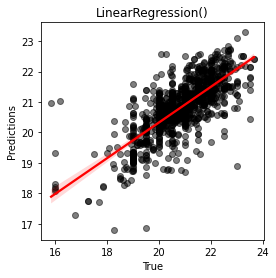

In [33]:
### Train the model again, see if it gets better score

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_no_outliers, y_no_outliers, test_size=0.25, random_state=42) 

# Calling the Linear Regression 
print("Linear Regression after removing outliers:", "\n")
fitting_model(LinearRegression(), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)


### Result
- Removing outliers significatly improved the Linear Regression model with R^2 of 56%
- But could it be better? Let's find out.

# Training using different models
- We will test out with both with and without outliers to see if we can see any different when using various models

## Training the models - Outliers included


 Linear Regression (baseline model): 

R^2:  -8.521397933709092e+23
MSE:  4.2196627240173873e+24
RMSE:  2054181765087.35
MAE:  306825665752.64

 SVR:  

R^2:  0.56
MSE:  2.17
RMSE:  1.47
MAE:  0.72

 Poisson Regressor:  

R^2:  0.1
MSE:  4.46
RMSE:  2.11
MAE:  0.94

 RandomForest Regressor:  

R^2:  0.55
MSE:  2.21
RMSE:  1.49
MAE:  0.53

 DecisionTree Regressor:  

R^2:  0.42
MSE:  2.86
RMSE:  1.69
MAE:  0.54

 KNeighborsRegressor:  

R^2:  0.44
MSE:  2.75
RMSE:  1.66
MAE:  0.53

 XGBRegressor:  

R^2:  0.6
MSE:  2.0
RMSE:  1.41
MAE:  0.56

 DummyRegressor model (no outliers): 

R^2:  -0.0
MSE:  4.97
RMSE:  2.23
MAE:  1.07

 TweedieRegressor model (no outliers): 

R^2:  0.01
MSE:  4.91
RMSE:  2.22
MAE:  1.06


array([20.67124232, 20.76342951, 20.65986874, ..., 20.71786729,
       20.76064217, 20.75017621])

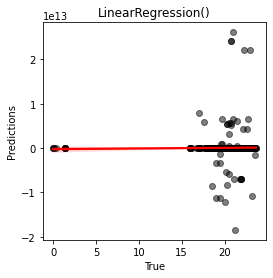

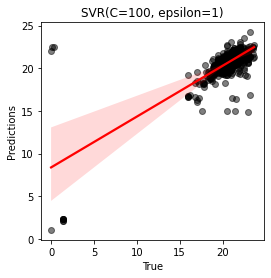

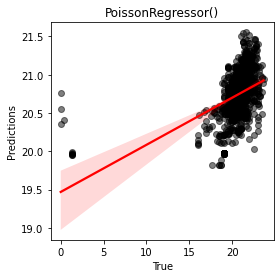

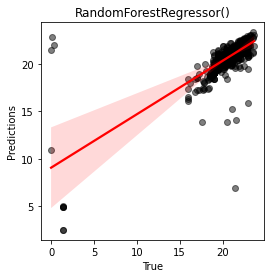

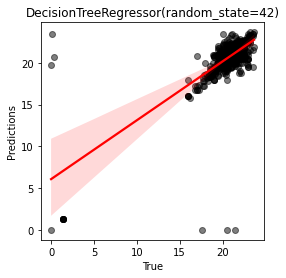

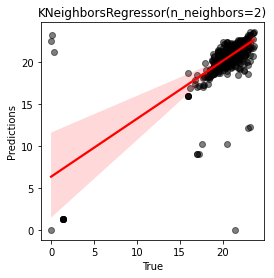

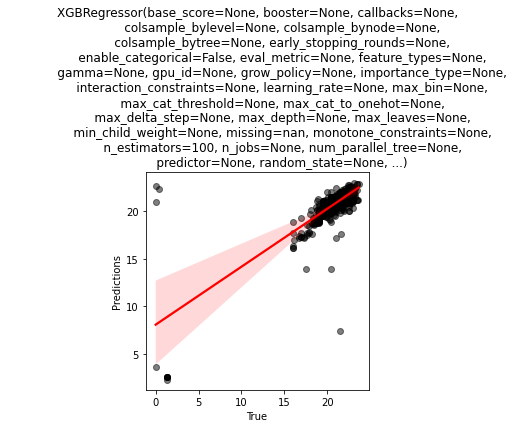

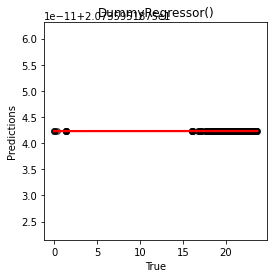

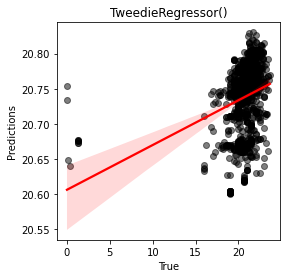

In [34]:
### Train with outliers

print("\n", "Linear Regression (baseline model):", "\n")
lin_predictions = fitting_model(LinearRegression(), X_train_base, X_test_base, y_train_base, y_test_base)
#print(lin_predictions, "\n")


print("\n", "SVR: ", "\n")
svr_predictions = fitting_model(SVR(kernel = 'rbf', C=100, epsilon=1), X_train_base, X_test_base, y_train_base, y_test_base)
#print(svr_predictions, "\n")


print("\n", "Poisson Regressor: ", "\n")
ps_predictions = fitting_model(PoissonRegressor(), X_train_base, X_test_base, y_train_base, y_test_base)
#print(ps_predictions, "\n")

print("\n", "RandomForest Regressor: ", "\n")
rf_predictions = fitting_model(RandomForestRegressor(), X_train_base, X_test_base, y_train_base, y_test_base)
#print(rf_predictions, "\n")


print("\n", "DecisionTree Regressor: ", "\n")
dtr_predictions = fitting_model(DecisionTreeRegressor(random_state = 42), X_train_base, X_test_base, y_train_base, y_test_base)
#print(dtr_predictions, "\n")


print("\n", "KNeighborsRegressor: ", "\n")
dtr_predictions = fitting_model(KNeighborsRegressor(n_neighbors=2), X_train_base, X_test_base, y_train_base, y_test_base)
#print(dtr_predictions, "\n")


print("\n", "XGBRegressor: ", "\n")
dtr_predictions = fitting_model(XGBRegressor(), X_train_base, X_test_base, y_train_base, y_test_base)
#print(dtr_predictions, "\n")


print("\n", "DummyRegressor model (no outliers):", "\n")
fitting_model(DummyRegressor(), X_train_base, X_test_base, y_train_base, y_test_base)


print("\n", "TweedieRegressor model (no outliers):", "\n")
fitting_model(TweedieRegressor(), X_train_base, X_test_base, y_train_base, y_test_base)

### Observation
- Eventhough, we trained the models with those outliers included. Some models predicted the the target quite good e.g. SVR and RandomForest with R^2 over 50% and XGBRegressor with R^2 of 60%

### Next
- We will train the same models without outliers. Let's see how much better the models can predict our target

## Training the models - Outliers excluded

Linear Regression (no outliers): 

R^2:  0.56
MSE:  0.6
RMSE:  0.78
MAE:  0.55

 SVR (no outliers):  

R^2:  0.46
MSE:  0.73
RMSE:  0.86
MAE:  0.67

 Poisson Regressor (no outliers):  

R^2:  0.23
MSE:  1.04
RMSE:  1.02
MAE:  0.78

 RandomForest Regressor (no outliers):  

R^2:  0.69
MSE:  0.42
RMSE:  0.65
MAE:  0.41

 DecisionTree Regressor (no outliers):  

R^2:  0.58
MSE:  0.57
RMSE:  0.75
MAE:  0.45

 KNeighborsRegressor (no outliers):  

R^2:  0.41
MSE:  0.81
RMSE:  0.9
MAE:  0.58

 XGBRegressor (no outliers):  

R^2:  0.66
MSE:  0.46
RMSE:  0.68
MAE:  0.47

 DummyRegressor model (no outliers): 

R^2:  -0.0
MSE:  1.36
RMSE:  1.17
MAE:  0.9

 TweedieRegressor model (no outliers): 

R^2:  0.04
MSE:  1.3
RMSE:  1.14
MAE:  0.89


array([20.75494619, 20.66403563, 20.79677675, ..., 20.89506983,
       20.77531481, 20.75052653])

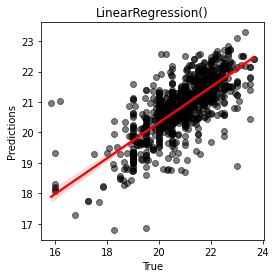

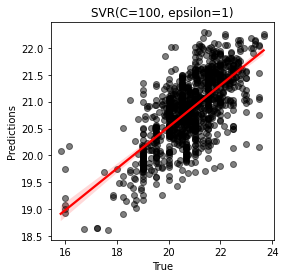

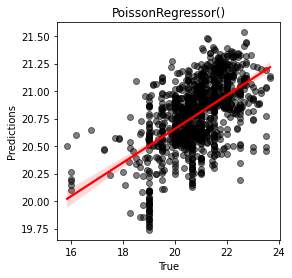

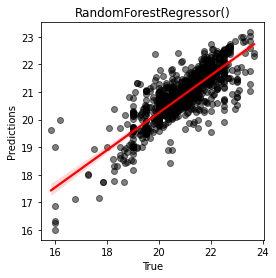

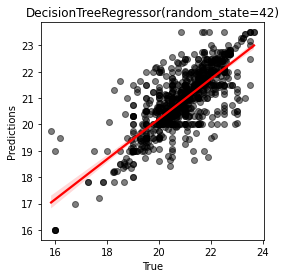

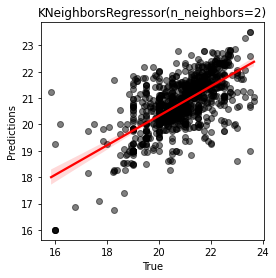

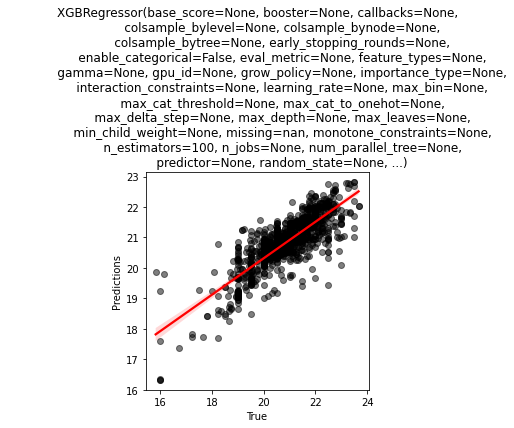

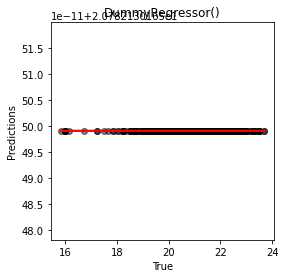

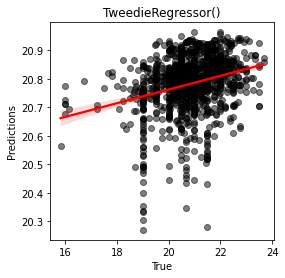

In [35]:
### Train without outliers

print("Linear Regression (no outliers):", "\n")
lin_predictions = fitting_model(LinearRegression(), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)

print("\n", "SVR (no outliers): ", "\n")
svr_predictions = fitting_model(SVR(kernel = 'rbf', C=100, epsilon=1), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)

print("\n", "Poisson Regressor (no outliers): ", "\n")
ps_predictions = fitting_model(PoissonRegressor(), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)

print("\n", "RandomForest Regressor (no outliers): ", "\n")
rf_predictions = fitting_model(RandomForestRegressor(), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)

print("\n", "DecisionTree Regressor (no outliers): ", "\n")
dtr_predictions = fitting_model(DecisionTreeRegressor(random_state = 42), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)

print("\n", "KNeighborsRegressor (no outliers): ", "\n")
dtr_predictions = fitting_model(KNeighborsRegressor(n_neighbors=2), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)

print("\n", "XGBRegressor (no outliers): ", "\n")
dtr_predictions = fitting_model(XGBRegressor(), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)

print("\n", "DummyRegressor model (no outliers):", "\n")
fitting_model(DummyRegressor(), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)

print("\n", "TweedieRegressor model (no outliers):", "\n")
fitting_model(TweedieRegressor(), X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers)


### Observation
- After removing outliers, most models were improved except KneighborRegressor (R^2 was lower a bit from 0.44 to 0.41). 
- RandomForest performed so much better and even better than the XGBRegressor. 

### Next
- We will train the same models but wiusing different appraoch to deal with outliers. 
- And we will not include the DummyRegressor and TweedieRegressor models because they are not useful at all. 

### 4.2 Capping outliers

In [36]:
df_capped = df.copy()

# define the limits
iqr = np.percentile(df['Start_decimal'],75) - np.percentile(df['Start_decimal'],25) 
upper_limit = np.percentile(df['Start_decimal'],75) + 1.5*iqr
lower_limit = np.percentile(df['Start_decimal'],25) - 1.5*iqr

df_capped['Start_decimal'] = np.where(df["Start_decimal"]> upper_limit, upper_limit,
                        np.where(df["Start_decimal"]< lower_limit, lower_limit, df["Start_decimal"]))

fig = px.histogram(df_capped['Start_decimal'], marginal="box") 
fig.show()

In [37]:
# Define y (target)
y_capped = df_capped['Start_decimal']

# Define X
X = df_capped[['Site', 'Taxon', 'N_min', 'Gamete_release', 'DoSRtNFM', 'daylen_decimal', 'sunset', 'sunrise']]

# Separate categorical and numerical data
cat = X.select_dtypes(include='object')
num = X.select_dtypes(include='number')

# Encoding categorical data
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(cat)
encoded = encoder.transform(cat).toarray() # transform step = encoding step --> get an array as a result 
cat_encoded = pd.DataFrame(encoded).reset_index(drop=True) # put the array into a data frame
cat_encoded.columns = encoder.get_feature_names_out() # name the columns after transformation
cat_encoded.shape

# Concat categorical & numerical data into one data frame, X
X_capped = pd.concat([num, cat_encoded], axis=1)
print(X_capped.shape)
#X_capped.head()

(4396, 439)



 Linear Regression after capping outliers: 

R^2:  -1.3707225318724422e+21
MSE:  1.8064489291906078e+21
RMSE:  42502340278.98
MAE:  5766392942.9

 SVR after capping outliers:  

R^2:  0.48
MSE:  0.68
RMSE:  0.83
MAE:  0.66

 Poisson Regressor after capping outliers:  

R^2:  0.25
MSE:  0.99
RMSE:  1.0
MAE:  0.76

 RandomForest Regressor after capping outliers:  

R^2:  0.69
MSE:  0.41
RMSE:  0.64
MAE:  0.41

 DecisionTree Regressor after capping outliers:  

R^2:  0.54
MSE:  0.6
RMSE:  0.78
MAE:  0.44

 KNeighborsRegressor after capping outliers:  

R^2:  0.44
MSE:  0.74
RMSE:  0.86
MAE:  0.56

 XGBRegressor after capping outliers:  

R^2:  0.64
MSE:  0.47
RMSE:  0.68
MAE:  0.49


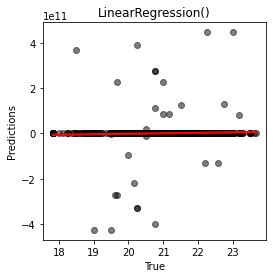

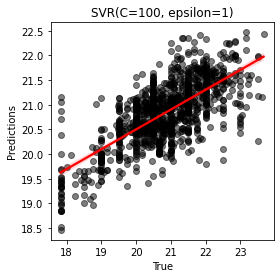

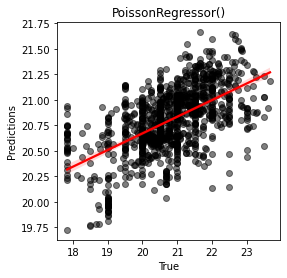

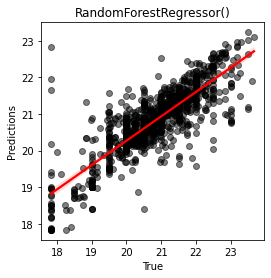

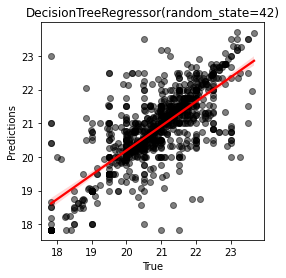

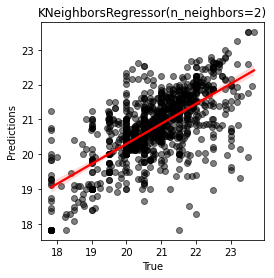

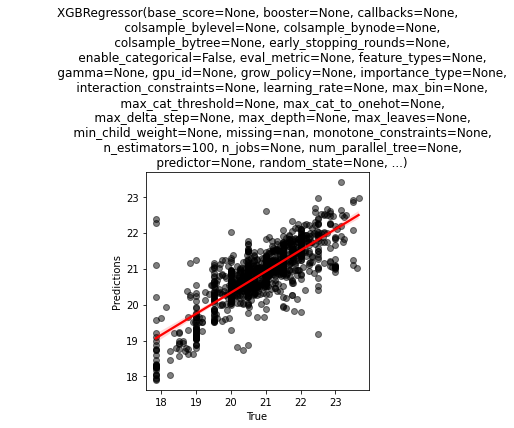

In [38]:
### Train the model again, see if it gets better score
# 25% of data --> test set, 75% --> train set
X_train, X_test, y_train, y_test = train_test_split(X_capped, y_capped, test_size=0.25, random_state=42) 

# Calling the Linear Regression 
print("\n", "Linear Regression after capping outliers:", "\n")
fitting_model(LinearRegression(), X_train, X_test, y_train, y_test)

print("\n", "SVR after capping outliers: ", "\n")
svr_predictions = fitting_model(SVR(kernel = 'rbf', C=100, epsilon=1), X_train, X_test, y_train, y_test)

print("\n", "Poisson Regressor after capping outliers: ", "\n")
ps_predictions = fitting_model(PoissonRegressor(), X_train, X_test, y_train, y_test)

print("\n", "RandomForest Regressor after capping outliers: ", "\n")
rf_predictions = fitting_model(RandomForestRegressor(), X_train, X_test, y_train, y_test)

print("\n", "DecisionTree Regressor after capping outliers: ", "\n")
dtr_predictions = fitting_model(DecisionTreeRegressor(random_state = 42), X_train, X_test, y_train, y_test)

print("\n", "KNeighborsRegressor after capping outliers: ", "\n")
dtr_predictions = fitting_model(KNeighborsRegressor(n_neighbors=2), X_train, X_test, y_train, y_test)

print("\n", "XGBRegressor after capping outliers: ", "\n")
dtr_predictions = fitting_model(XGBRegressor(), X_train, X_test, y_train, y_test)

### Result

- Capping outliers did not improve the LinearRegression model compared to the baseline (training with outliers)
- Though it improved other models but not better than the ones with outliers removed

### Next
- We will try winsorize the outliers

---

### 4.3 Winsorizing outliers

In [39]:
#Create copy of df
df_win = df.copy()

#Winsorize on left-tail
df_win['Start_decimal'] = winsorize(df['Start_decimal'], limits=(0.025, 0))

fig = px.histogram(df_win['Start_decimal'], marginal="box") 
fig.show()

In [40]:
# Define y (target)
y_win = df_win['Start_decimal']

# Define X
X = df_win[['Site', 'Taxon', 'N_min',
                    'Gamete_release', 'DoSRtNFM', 'daylen_decimal', 'sunset', 'sunrise']]

# Separate categorical and numerical data
cat = X.select_dtypes(include='object')
num = X.select_dtypes(include='number')

# Encoding categorical data
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(cat)
encoded = encoder.transform(cat).toarray() # transform step = encoding step --> get an array as a result 
cat_encoded = pd.DataFrame(encoded).reset_index(drop=True) # put the array into a data frame
cat_encoded.columns = encoder.get_feature_names_out() # name the columns after transformation
cat_encoded.shape

# Concat categorical & numerical data into one data frame, X
X_winsorized = pd.concat([num.reset_index(drop=True), cat_encoded], axis=1)
print(X_winsorized.shape)
#X_winsorized.head()

(4396, 439)



 Linear Regression (winsorized outliers): 

R^2:  -1.1367602791999607e+21
MSE:  1.376403423290084e+21
RMSE:  37099911364.99
MAE:  5033432645.72

 SVR (winsorized outliers):  

R^2:  0.48
MSE:  0.63
RMSE:  0.8
MAE:  0.64

 Poisson Regressor (winsorized outliers):  

R^2:  0.25
MSE:  0.91
RMSE:  0.95
MAE:  0.75

 RandomForest Regressor (winsorized outliers):  

R^2:  0.69
MSE:  0.38
RMSE:  0.62
MAE:  0.4

 DecisionTree Regressor (winsorized outliers):  

R^2:  0.54
MSE:  0.56
RMSE:  0.75
MAE:  0.43

 KNeighborsRegressor (winsorized outliers):  

R^2:  0.42
MSE:  0.7
RMSE:  0.83
MAE:  0.55

 XGBRegressor after (winsorized outliers):  

R^2:  0.63
MSE:  0.45
RMSE:  0.67
MAE:  0.48


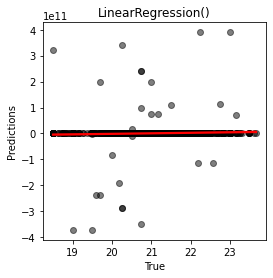

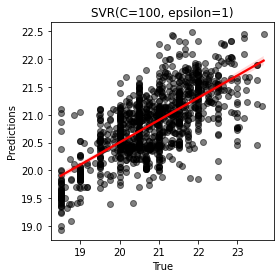

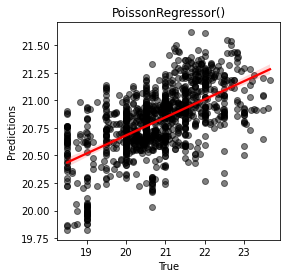

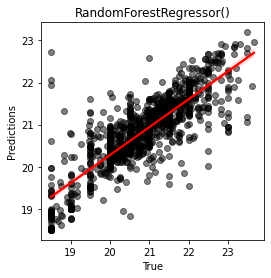

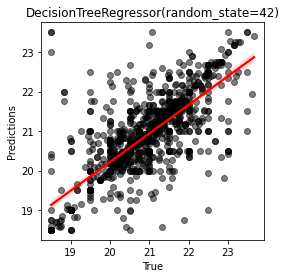

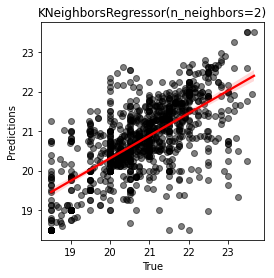

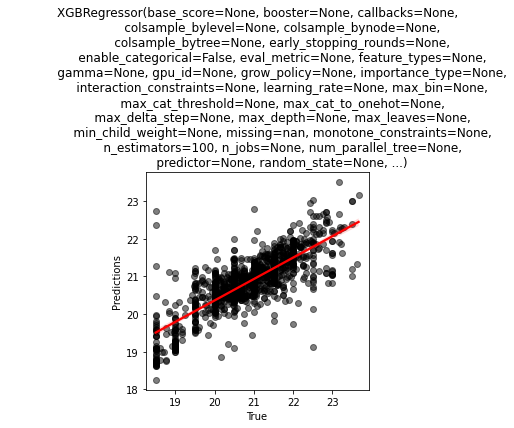

In [41]:
### Train the model again, see if it gets better score

# 25% of data --> test set, 75% --> train set
X_train, X_test, y_train, y_test = train_test_split(X_winsorized, y_win, test_size=0.25, random_state=42) 

print("\n", "Linear Regression (winsorized outliers):", "\n")
fitting_model(LinearRegression(), X_train, X_test, y_train, y_test)

print("\n", "SVR (winsorized outliers): ", "\n")
svr_predictions = fitting_model(SVR(kernel = 'rbf', C=100, epsilon=1), X_train, X_test, y_train, y_test)

print("\n", "Poisson Regressor (winsorized outliers): ", "\n")
ps_predictions = fitting_model(PoissonRegressor(), X_train, X_test, y_train, y_test)

print("\n", "RandomForest Regressor (winsorized outliers): ", "\n")
rf_predictions = fitting_model(RandomForestRegressor(), X_train, X_test, y_train, y_test)

print("\n", "DecisionTree Regressor (winsorized outliers): ", "\n")
dtr_predictions = fitting_model(DecisionTreeRegressor(random_state = 42), X_train, X_test, y_train, y_test)

print("\n", "KNeighborsRegressor (winsorized outliers): ", "\n")
dtr_predictions = fitting_model(KNeighborsRegressor(n_neighbors=2), X_train, X_test, y_train, y_test)

print("\n", "XGBRegressor after (winsorized outliers): ", "\n")
dtr_predictions = fitting_model(XGBRegressor(), X_train, X_test, y_train, y_test)

### Result 
- Winsorized outliers gave similar results to the capping method. Which did not improve the LinearRegression model but others. However, removing outliers is the best approach in this case.


#### Note:
- I also tried changing features by removing, adding some different columns and tested it out. This set of features that used to train the models above gave the best result. (But I do not include the process of features selection in this notebook because it will get too long.)


---

# Conclusion
- After tested total 31 models using different linear regression algorithms and training them with or without outliers, with capping outliers, and winsorizing outliers. We came to the conclusion that the RandomForest with outlier removed is the best model for this dataset.

---
